In [1]:
import boxball_loader as bbl

In [2]:
ev = bbl.load_event_data(1800, 3000, ['bat_id', 'pit_id', 'event_id'], True)
ev.columns

Index(['game_id', 'date', 'game_type', 'ab_fl', 'bat_event_fl', 'pit_id',
       'tb_ct', 'bat_id', 'event_cd', 'event_id', 'h_fl', 'ob_fl', 'yr'],
      dtype='object')

In [3]:
ev['matchup_ct'] = ev.sort_values(['bat_id', 'pit_id', 'date', 'event_id']).groupby(['bat_id', 'pit_id']).cumcount()
ev['first_matchup'] = (ev['matchup_ct']==0)
ev.sample(10)

,game_id,date,game_type,ab_fl,bat_event_fl,pit_id,tb_ct,bat_id,event_cd,event_id,h_fl,ob_fl,yr,matchup_ct,first_matchup
8886008,MON199206100,1992-06-10,RS,True,True,gardm001,0,bonib001,3,36,0,0,1992,10,False
9313007,CHN199504300,1995-04-30,RS,True,True,hereg001,0,johnh001,2,37,0,0,1995,2,False
10988047,SLN200308260,2003-08-26,RS,True,True,stepg001,0,gonza001,2,12,0,0,2003,0,True
5415853,SFN197009110,1970-09-11,RS,True,True,brewj102,0,lanih101,3,79,0,0,1970,16,False
9827532,PHI199709152,1997-09-15,RS,True,True,winsd001,0,olerj001,2,40,0,0,1997,3,False
3998574,SLN195908110,1959-08-11,RS,True,True,stond102,0,kirkw101,3,67,0,0,1959,0,True
13607300,OAK201705180,2017-05-18,RS,True,True,grays001,0,ramih003,3,24,0,0,2017,6,False
13706299,CHA201708212,2017-08-21,RS,True,True,coved001,4,buxtb001,23,39,1,1,2017,3,False
6091496,PIT197506070,1975-06-07,RS,True,True,rookj101,0,adamg101,3,6,0,0,1975,0,True
1239895,CLE193108142,1931-08-14,RS,True,True,rhodg101,1,morge102,20,58,1,1,1931,4,False


## How much prior history is there on average for a batter-pitcher matchup?

For every plate appearance, count how many times these batter and pitcher have faced each other already.  Then average this across all PAs for each year, to view the trend over time.

<AxesSubplot:xlabel='yr'>

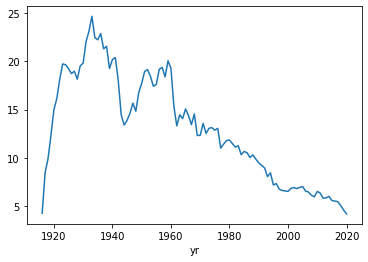

In [4]:
ev.groupby('yr')['matchup_ct'].mean().plot()

<AxesSubplot:xlabel='yr'>

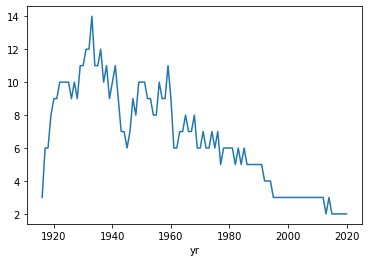

In [5]:
# Let's look at the median also

ev.groupby('yr')['matchup_ct'].median().plot()

## What fraction of PAs are "new" batter-pitcher matchups (e.g., no prior history)?

<AxesSubplot:xlabel='yr'>

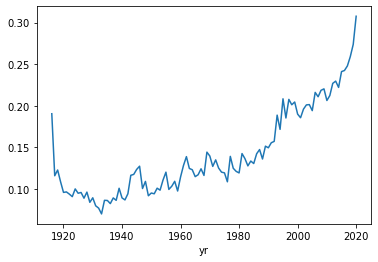

In [6]:
df = ev.groupby('yr')['first_matchup'].agg(func=[sum, len])
(df['sum']/df['len']).plot()

## How many pitchers does a typical full-time hitter face in a season?

In [7]:
pit_faced = ev.groupby(['bat_id', 'yr'])['pit_id'].nunique().rename('pitcher_ct')
pit_faced.sample(10), pit_faced.sort_values().tail(10)

(bat_id    yr  
 crabc001  2008    27
 owinm001  2007    40
 colar101  1959    84
 rodra101  1983    45
 axfoj001  2012     1
 rhemf101  1928    29
 montj003  2011    40
 tracs001  1995    33
 kenni001  2018     1
 alleg101  1969    86
 Name: pitcher_ct, dtype: int64,
 bat_id    yr  
 hollm001  2009    259
 semim001  2019    260
 escoe001  2018    260
 pillk001  2019    262
 hernc005  2019    263
 castn001  2019    267
 bogax001  2019    268
 mccua001  2018    271
 dever001  2019    275
 machm001  2018    276
 Name: pitcher_ct, dtype: int64)

<AxesSubplot:xlabel='yr'>

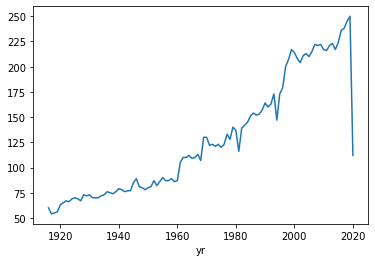

In [8]:
# For each year, choose the player with the 15th most pitchers faced in the year
pit_faced.sort_values(ascending=False).groupby('yr').nth(15).plot()

## How many distinct pitchers over a career?

In [9]:
h2h = ev.groupby('bat_id').agg(pitcher_ct=('pit_id', lambda x: x.nunique()), yr_last=('yr', max)).sort_values(by='pitcher_ct', ascending=False)
h2h.head(20)

,pitcher_ct,yr_last
bat_id,,
pujoa001,1604,2020
belta001,1555,2018
beltc001,1493,2017
vizqo001,1477,2012
rodra001,1454,2016
cabrm001,1402,2020
ortid001,1390,2016
rodri001,1368,2011
jeted001,1362,2014


In [10]:
h2h.query('bat_id=="robif103"')

,pitcher_ct,yr_last
bat_id,,
robif103,711,1976
